# DSCI 100 Group 84 Project Proposal
### Alyssa Aguason, Russell Ly, Sam Tong, Eric Yee

## Introduction

Auditing is the process of conducting financial examinations to investigate possibly fraudulent firms. An external investigation is done using quantitative financial data, and an internal investigation follows if the firm is at risk. The external process is a timely task that could be improved by using a classification model. Thus, our question is **can we build a classification model that will predict a firm’s risk of fraud and find whether or not this model would be accurate enough to use in an external auditing process?**

The data was collected by the Comptroller and Auditor General (CAG) of India for a total of 777 firms in the year 2015. The dataset contains observations of financial data that auditors use during the external investigation. Note that some predictive columns are already scaled, exceptions being the columns “PARA_A”, “PARA_B”, “TOTAL”, and “Money_Value”.


In [1]:
set.seed(1000)

library(repr)
library(tidyverse)
library(tidymodels)

<<<<<<< local
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
destfile <- "audit.zip"
download.file(url, destfile)

unzip("audit.zip", list = TRUE)

Name,Length,Date
<chr>,<dbl>,<dttm>
audit_data/audit_risk.csv,81197,2018-07-14 13:04:00
audit_data/trial.csv,39965,2018-07-14 12:47:00


In [3]:
# trial.csv has just the data with no risk evaluation scores from the original data collector's models, so that is what we will use in this project
audit_data <- read_csv(unzip("audit.zip", "audit_data/trial.csv")) |>
    mutate(Risk = as_factor(Risk))
head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


In [5]:
audit_prop <- audit_data |>
    group_by(Risk) |>
    summarize(count = n())
audit_prop

audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_train <- training(audit_split)
audit_test <- testing(audit_split)

Risk,count
<fct>,<int>
0,290
1,486


In [6]:
mean_train <- audit_train |>
    group_by(Risk) |>
    summarize(mean_para_a = mean(PARA_A),
              mean_para_b = mean(PARA_B),
              mean_money_value = mean(Money_Value, na.rm = TRUE),
              mean_sector_score = mean(Sector_score),
              mean_loss_score = mean(LOSS_SCORE),
              mean_history_score = mean(History_score),
              mean_district_score = mean(District))
mean_train

# THIS IS THE SUMMARY TABLE
# It is a table outlining the average (mean) values of each variable we are planning on using from the training data, 
# separated by risk score (0 = businesses not detected of fraud, 1 = businesses detected of fraud).

Risk,mean_para_a,mean_para_b,mean_money_value,mean_sector_score,mean_loss_score,mean_history_score,mean_district_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2876959,0.2527912,0.3009862,32.66742,2.000000,2.00000,2.000000
1,3.8406885,18.8677473,24.2730769,13.67192,2.093407,2.28022,2.736264


In [7]:
options(repr.plot.width = 18, repr.plot.height = 8)

select_audit_train <- audit_train |>
    select(c(Risk, PARA_A, PARA_B, Money_Value, Sector_score, LOSS_SCORE, History_score, District)) |>
    filter(PARA_A < 50, PARA_B < 1000, Money_Value < 350) # high-value outliers removed for visual clarity and less empty space 

# Histograms for numeric variables
para_A <- ggplot(select_audit_train, aes(x = PARA_A, fill = Risk)) +
    geom_histogram(binwidth = 1.5) +
    xlab("Discrepency between Planned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

para_B <- ggplot(select_audit_train, aes(x = PARA_B, fill = Risk)) +
    geom_histogram(binwidth = 25) +
    xlab("Discrepency between Unplanned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

money_value <- ggplot(select_audit_train, aes(x = Money_Value, fill = Risk)) +
    geom_histogram(binwidth = 20) +
    xlab("Amount of Money Involved in Misstatements in Past Audits in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

sector <- ggplot(select_audit_train, aes(x = Sector_score, fill = Risk)) +
    geom_histogram(binwidth = 3) +
    xlab("Historical Risk Score of Associated Sector") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

# Barplots for assigned score variables
loss <- ggplot(select_audit_train, aes(x = LOSS_SCORE, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Loss Suffered by Firm in Previous Year") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

history <- ggplot(select_audit_train, aes(x = History_score, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Average Historical Loss Suffered by Firm in Past 10 Years") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

district <- ggplot(select_audit_train, aes(x = District, fill = Risk)) +
    geom_bar() +
    xlab("Assigned Score of Average Historical Risk Score of District in Past 10 Years") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

# For assigned scores, larger is more.
# There are few columns in the non-fraudulent graphs because there is often 
# little/no discrepency found in audit reports for non-fraudulent businesses.

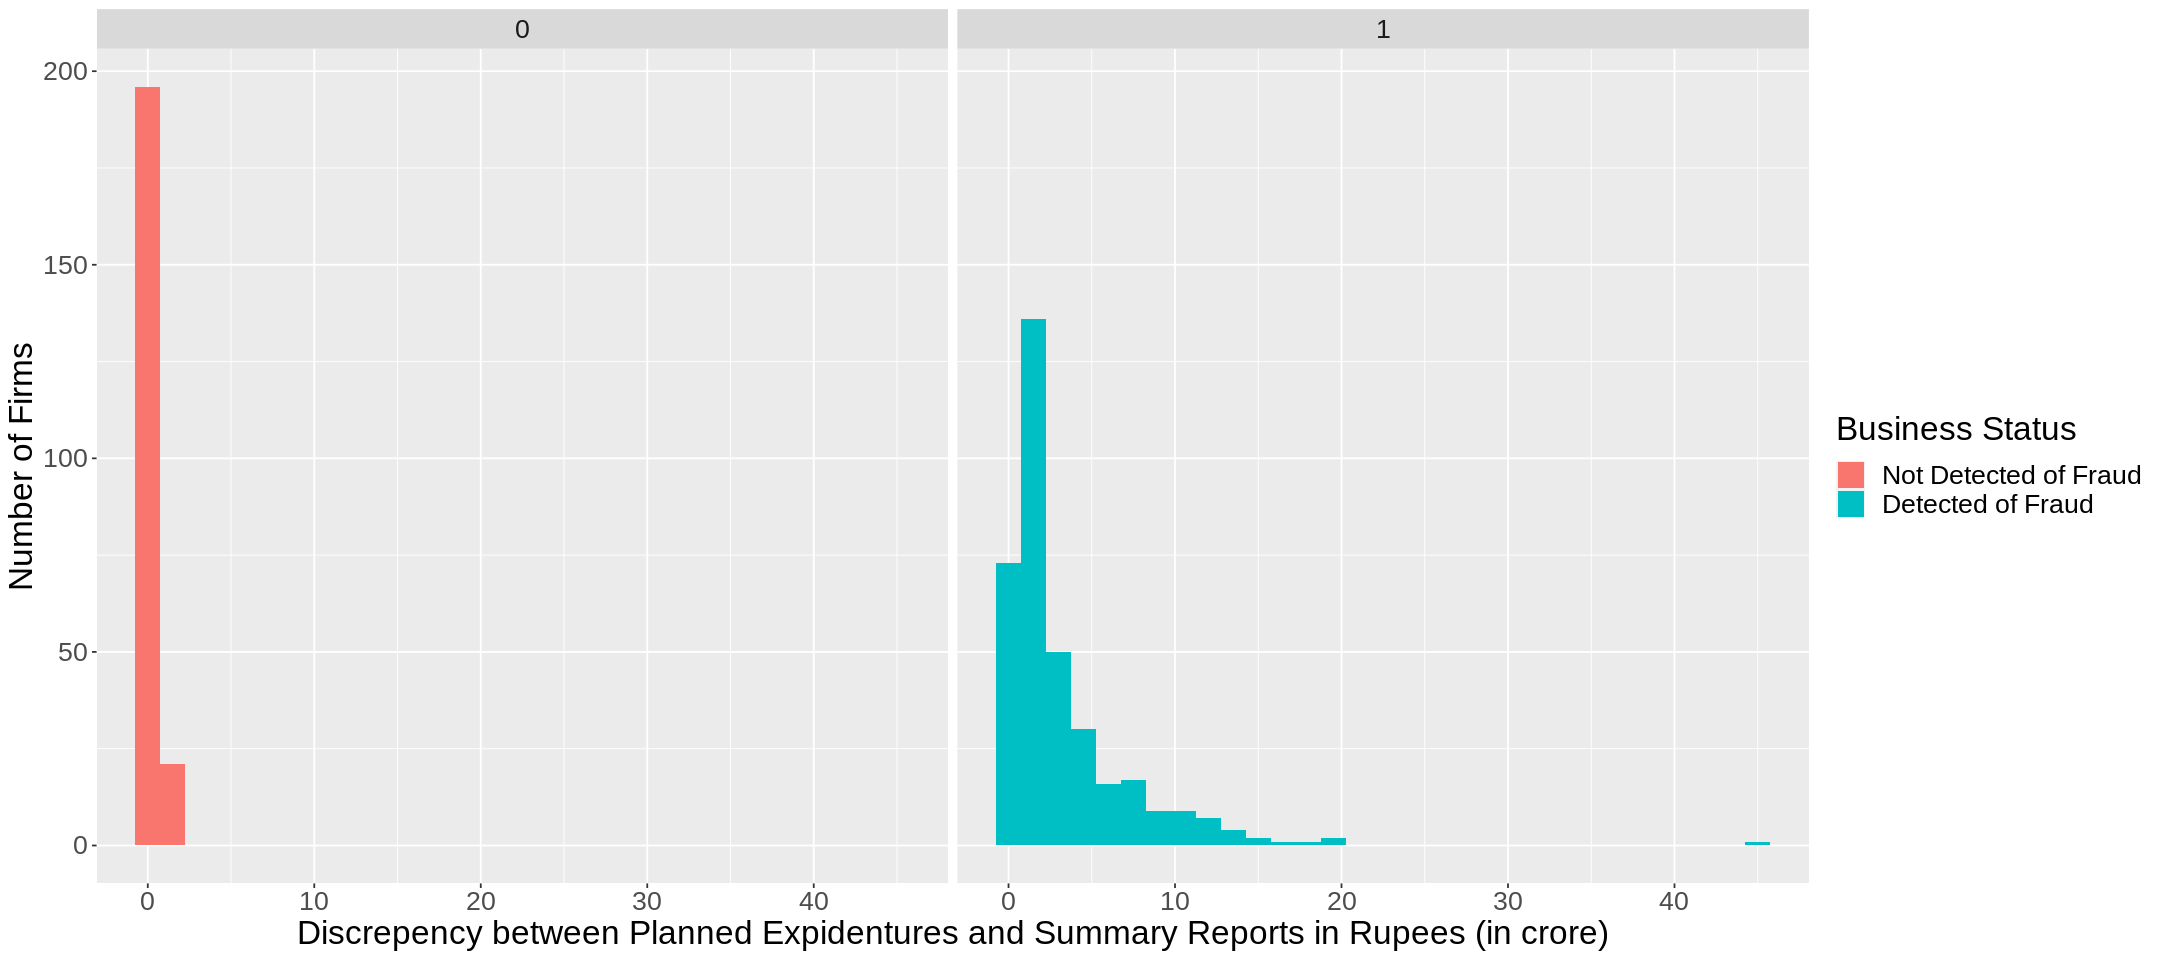

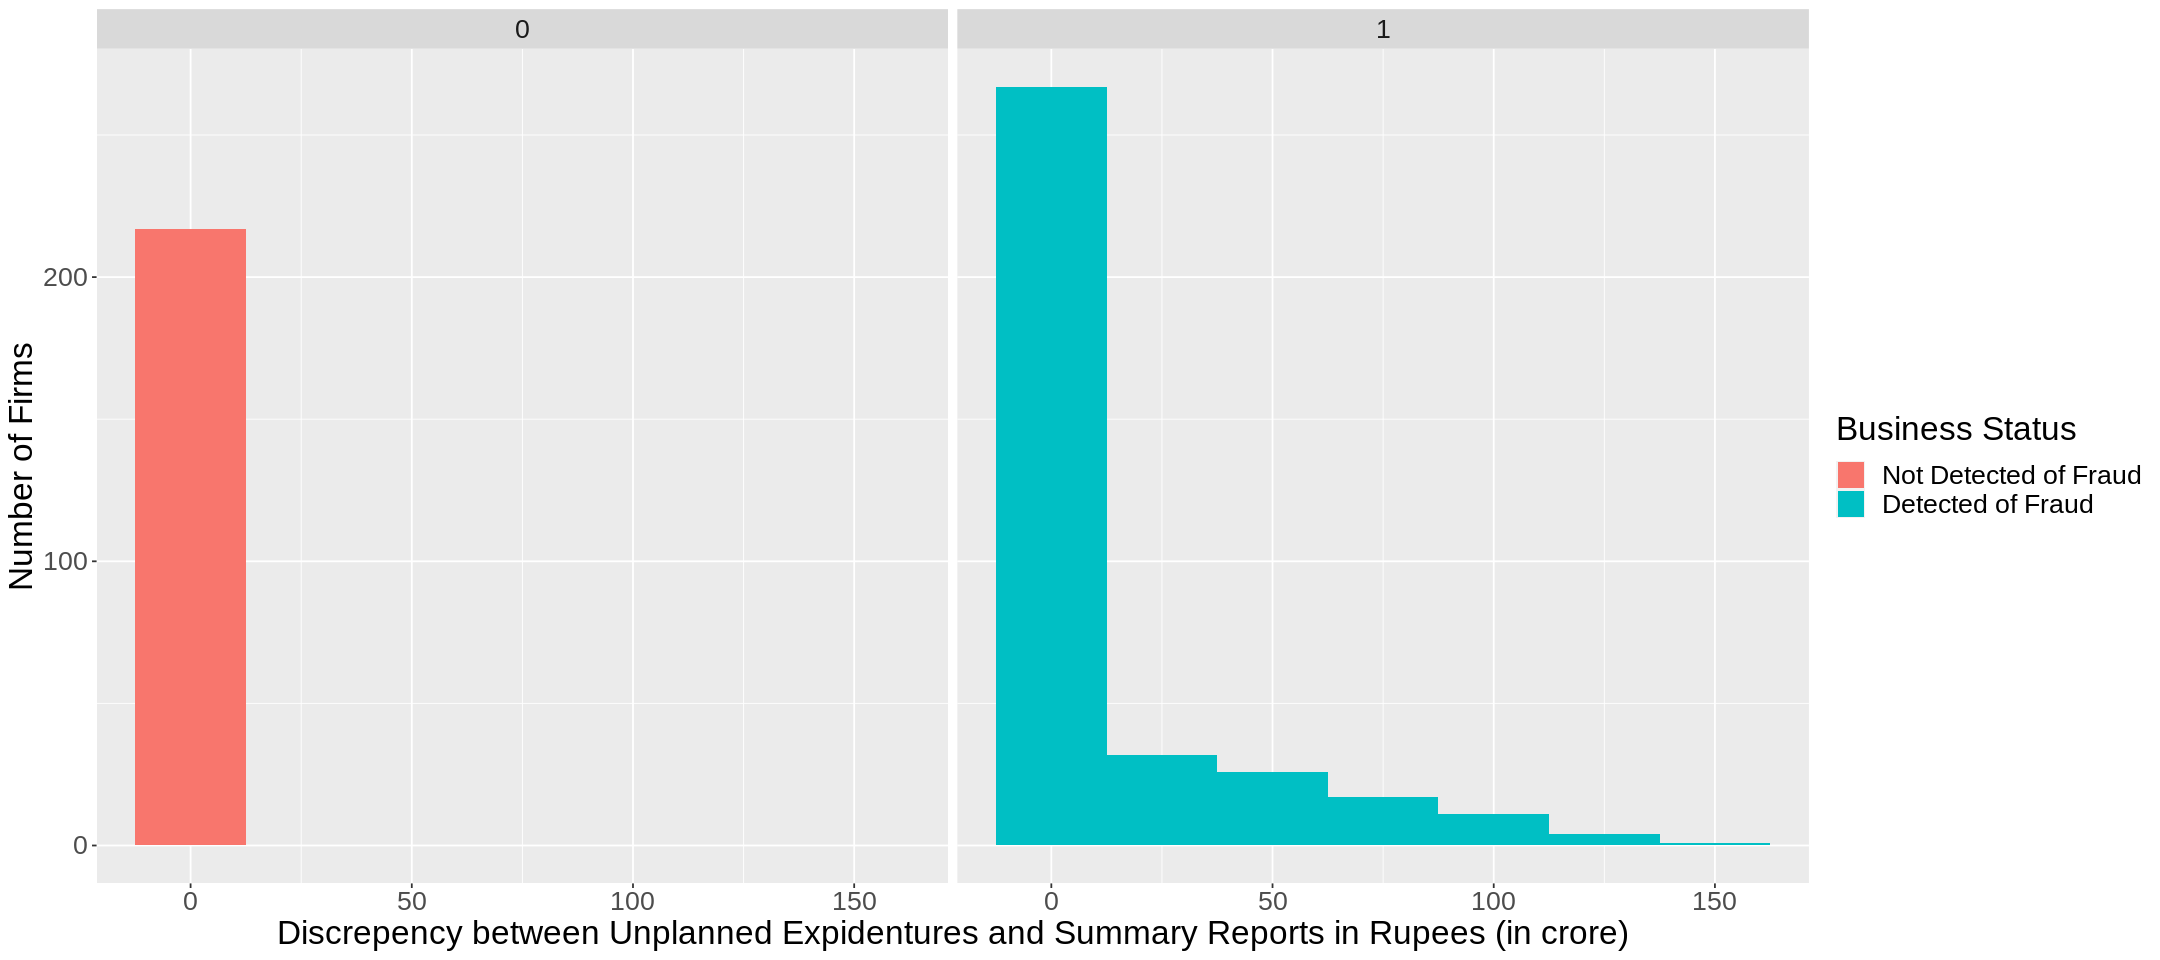

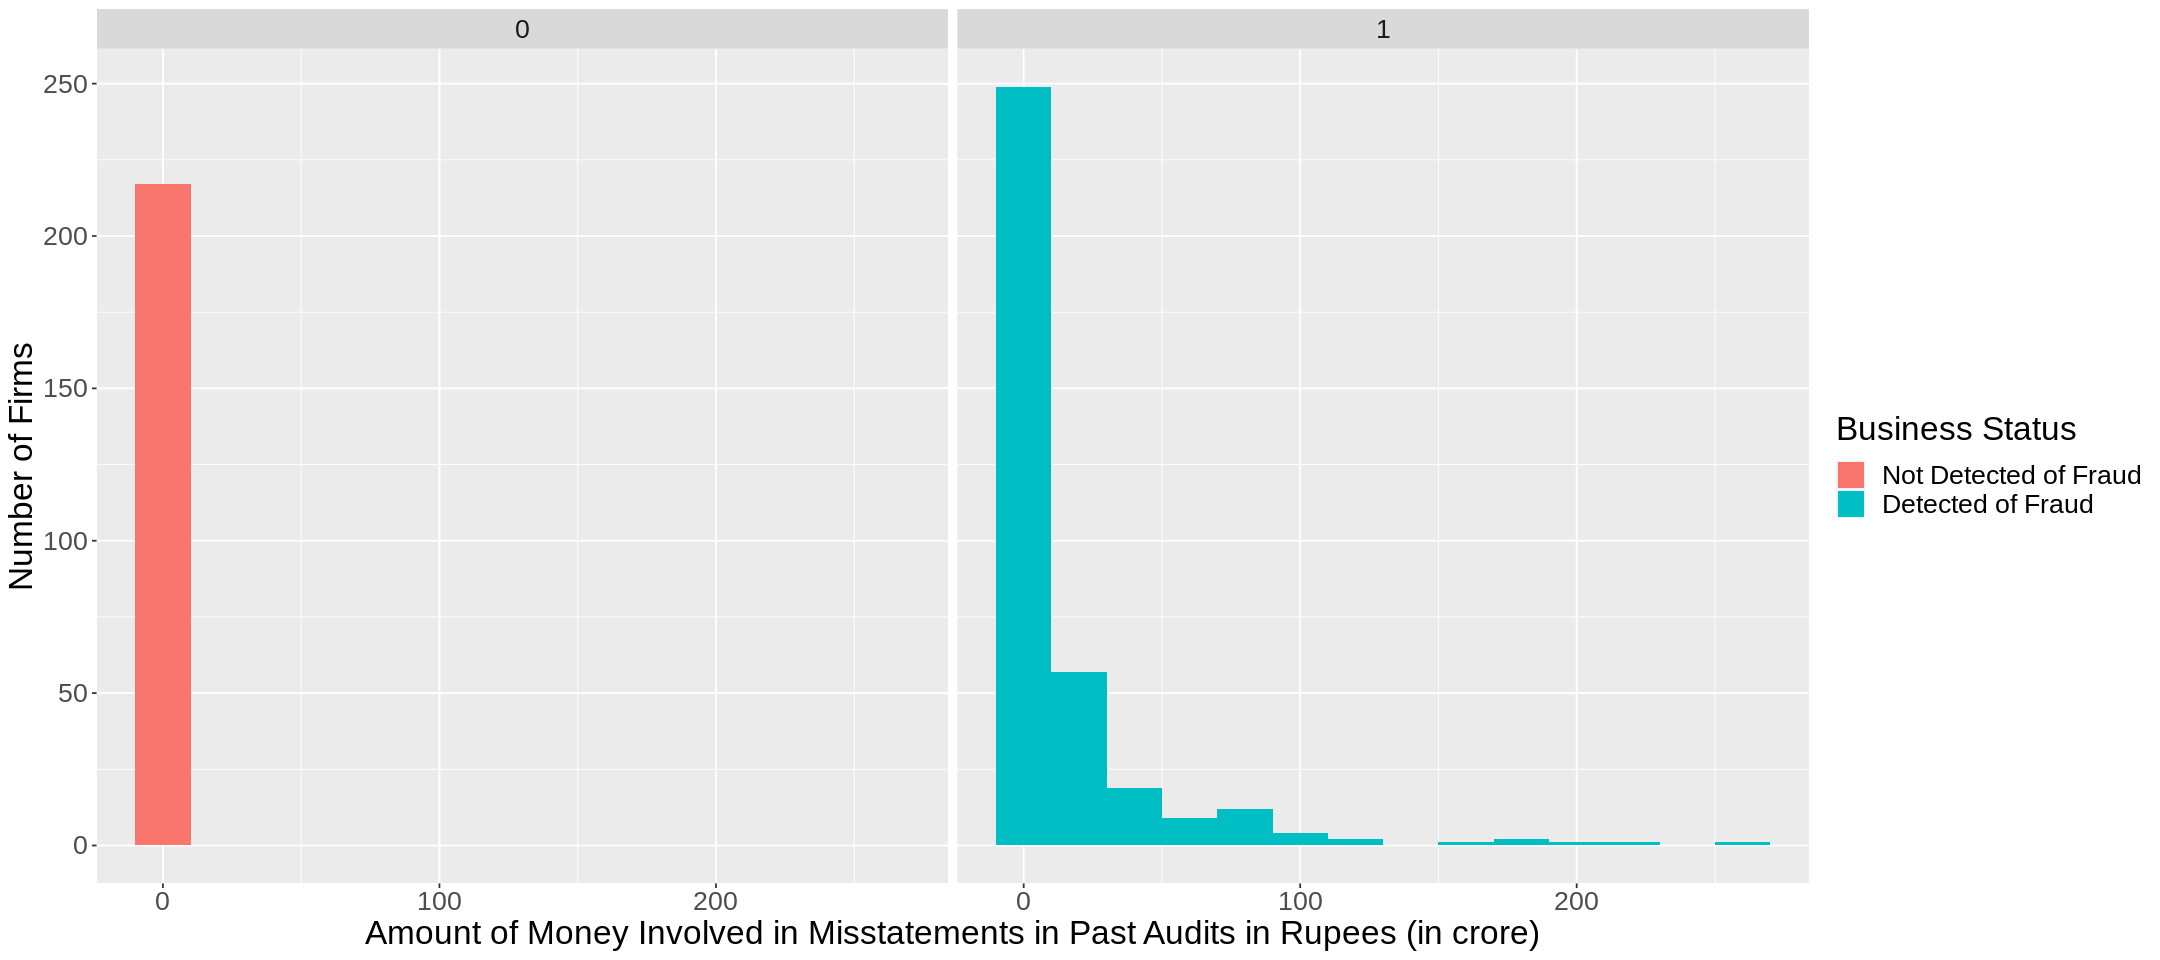

In [8]:
# INHERIT RISK FACTORS
para_A
para_B
money_value

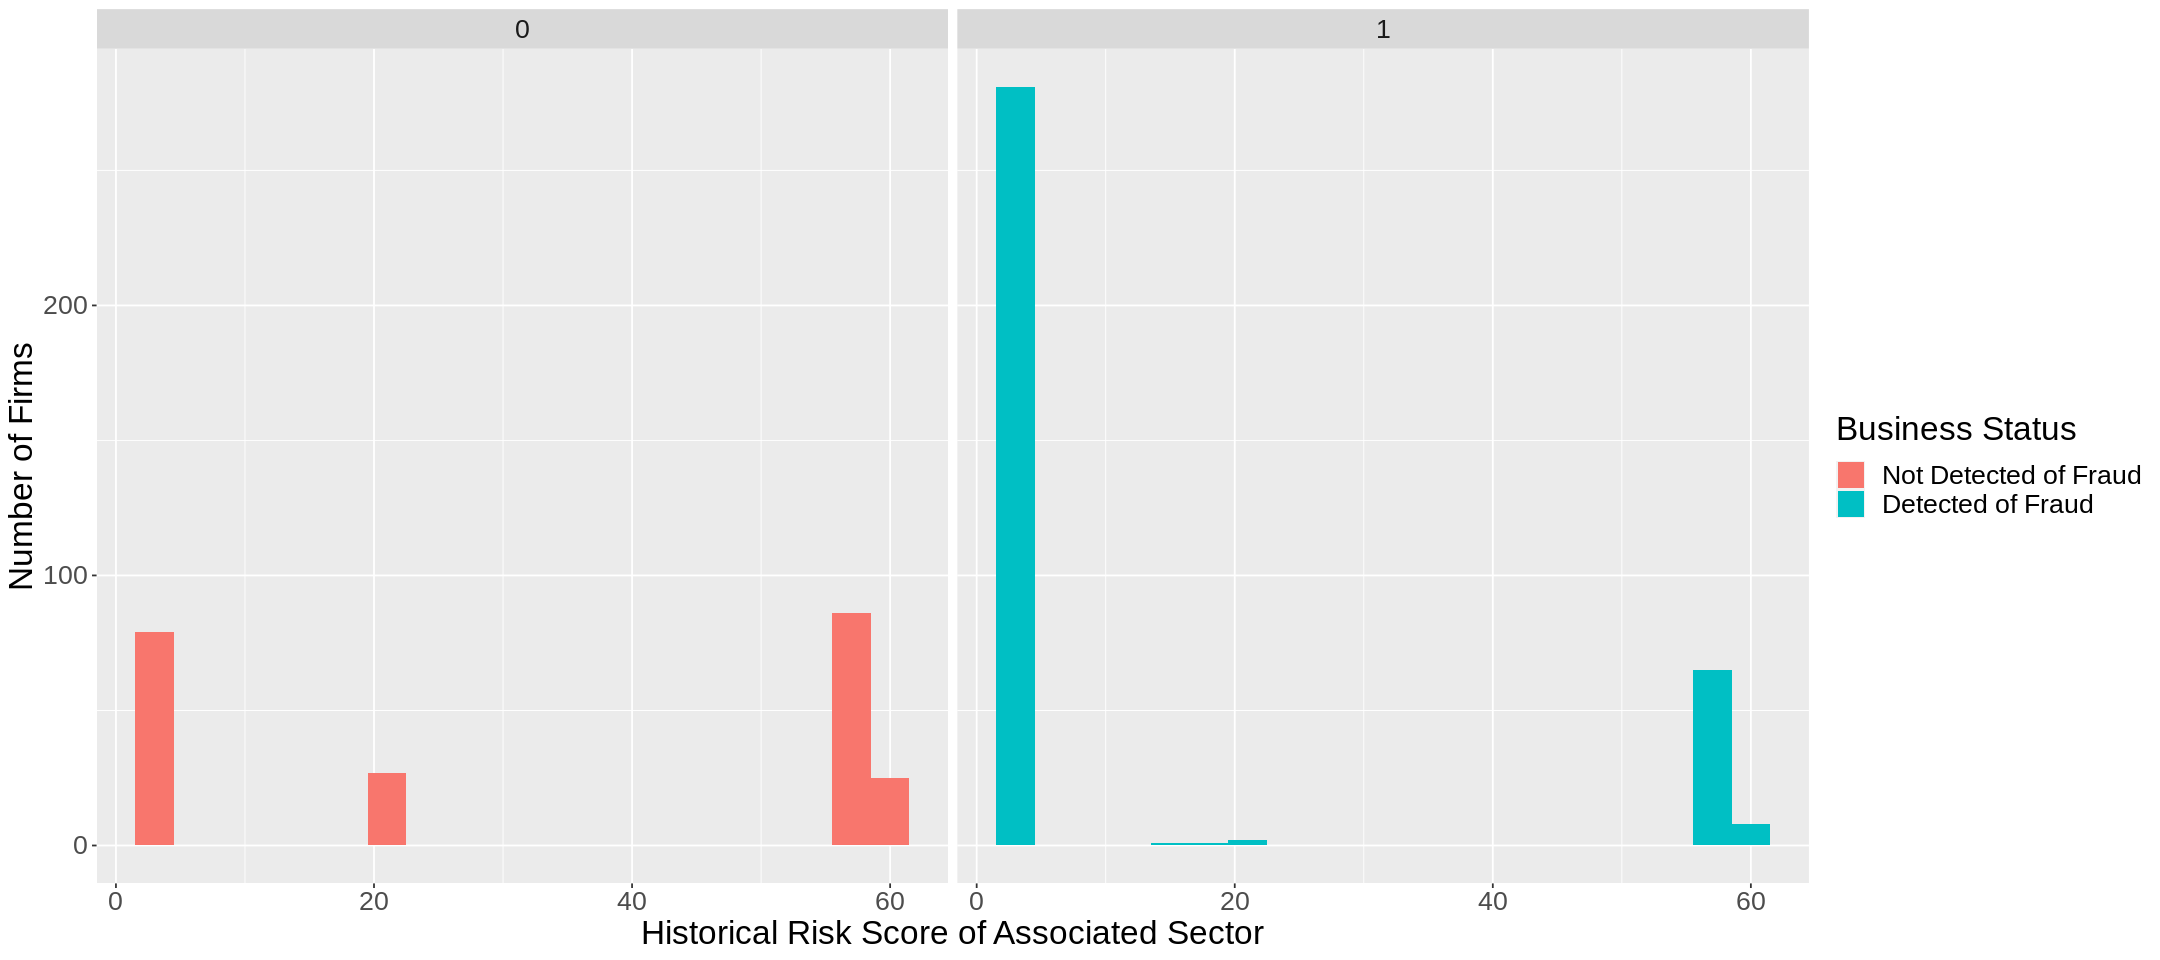

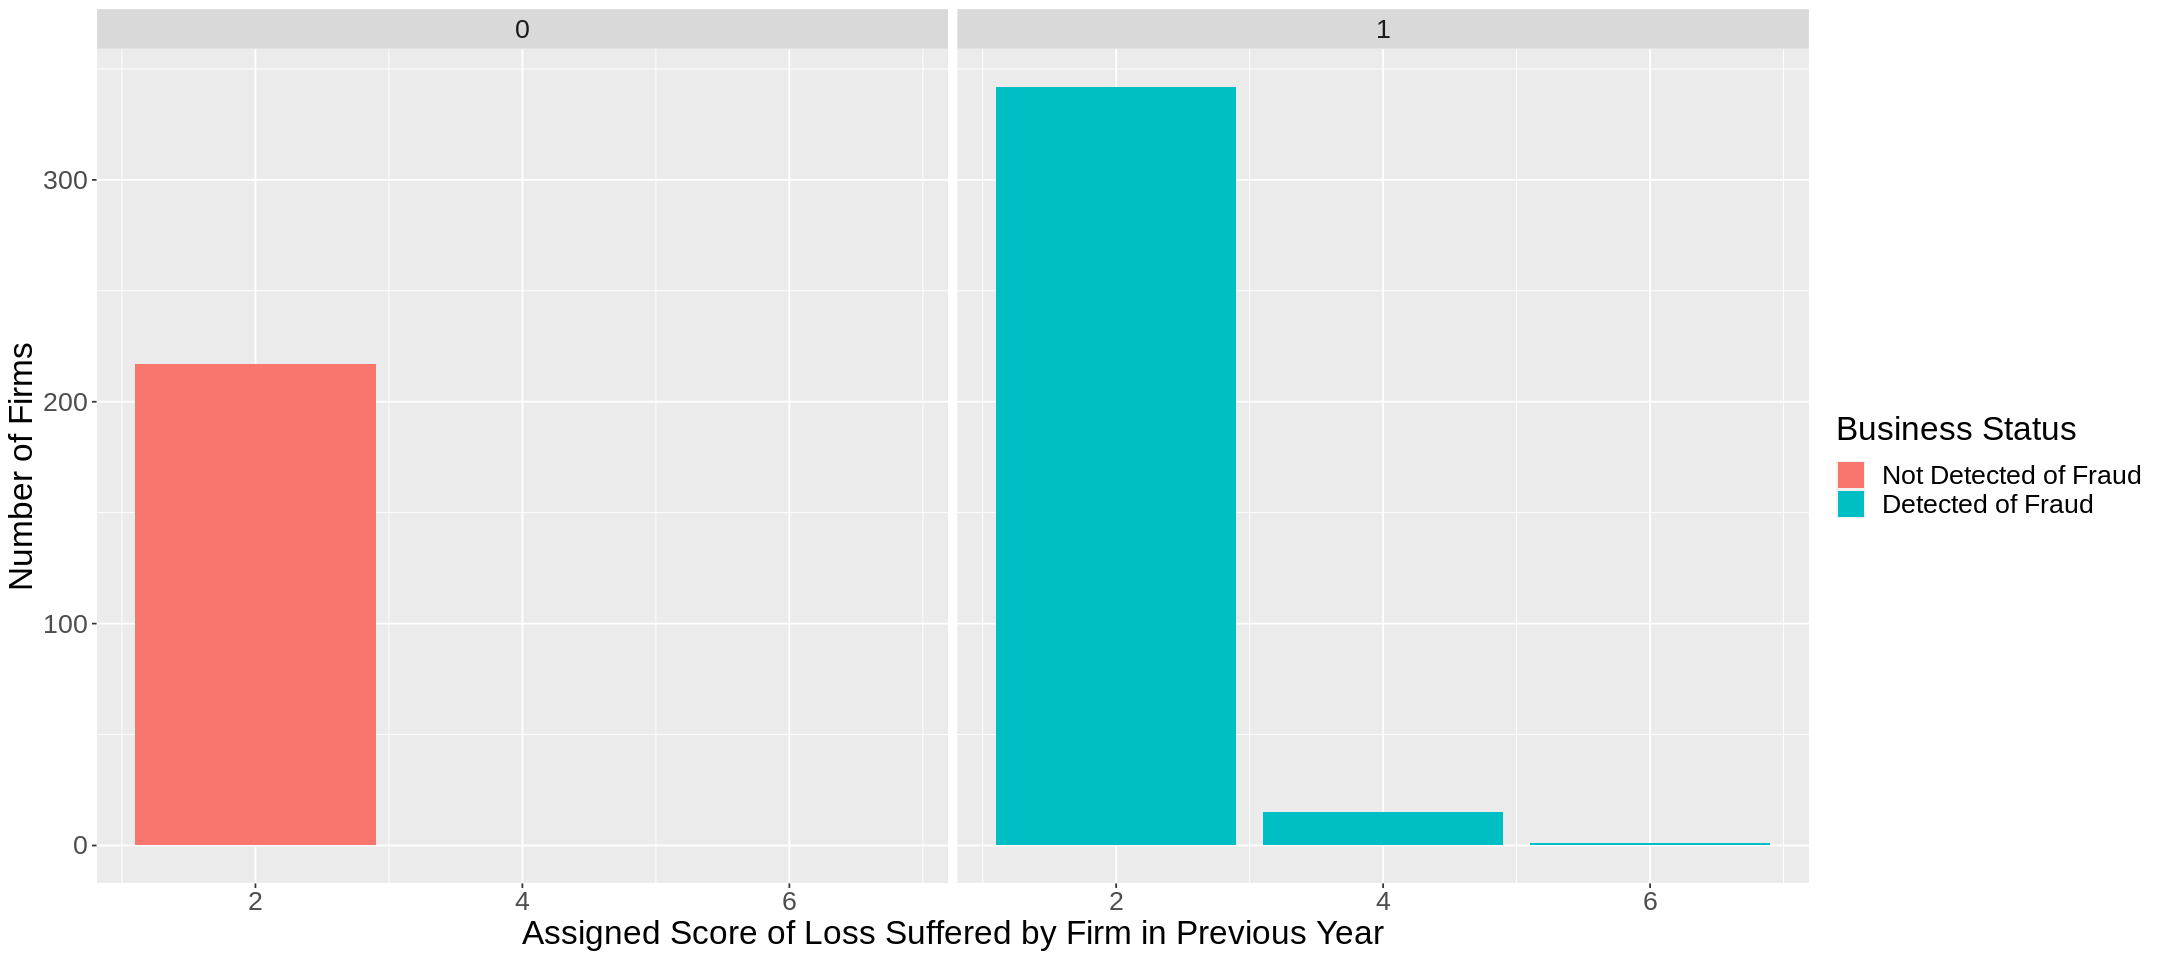

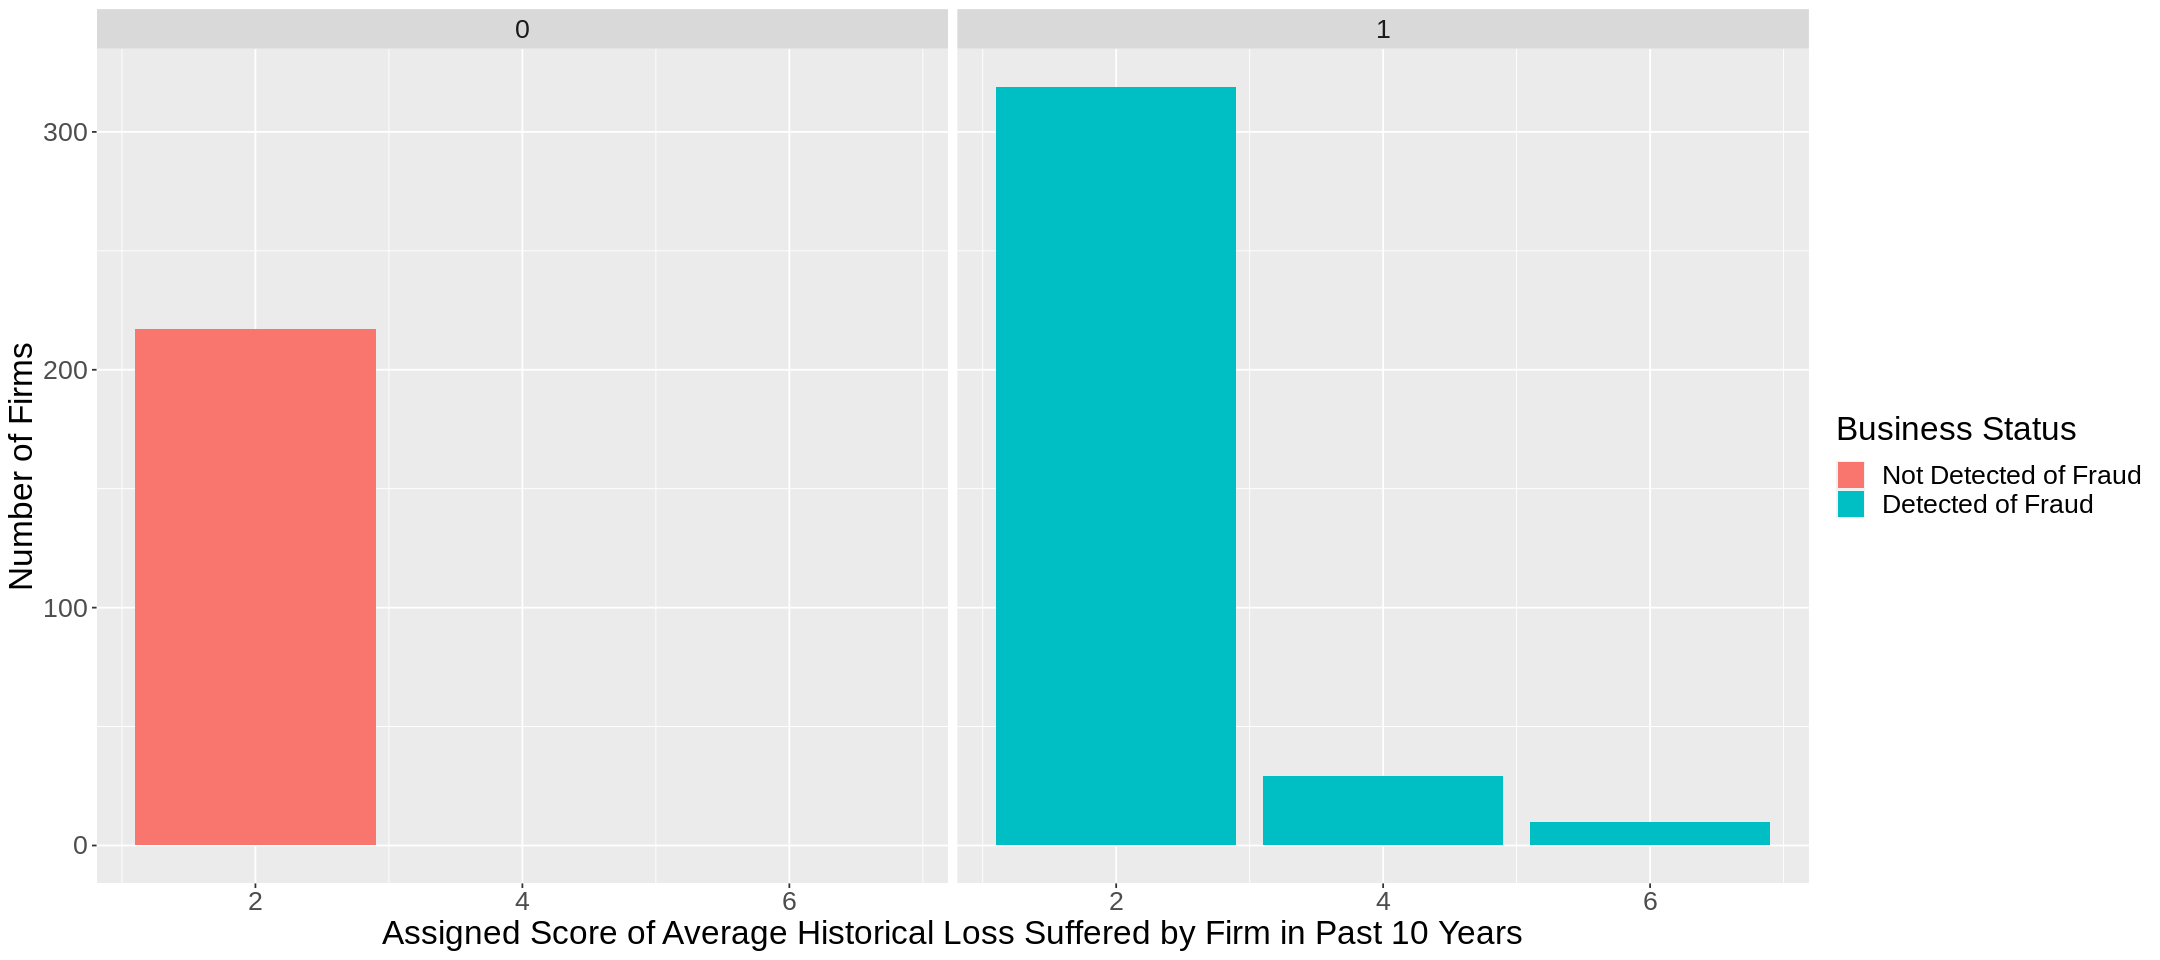

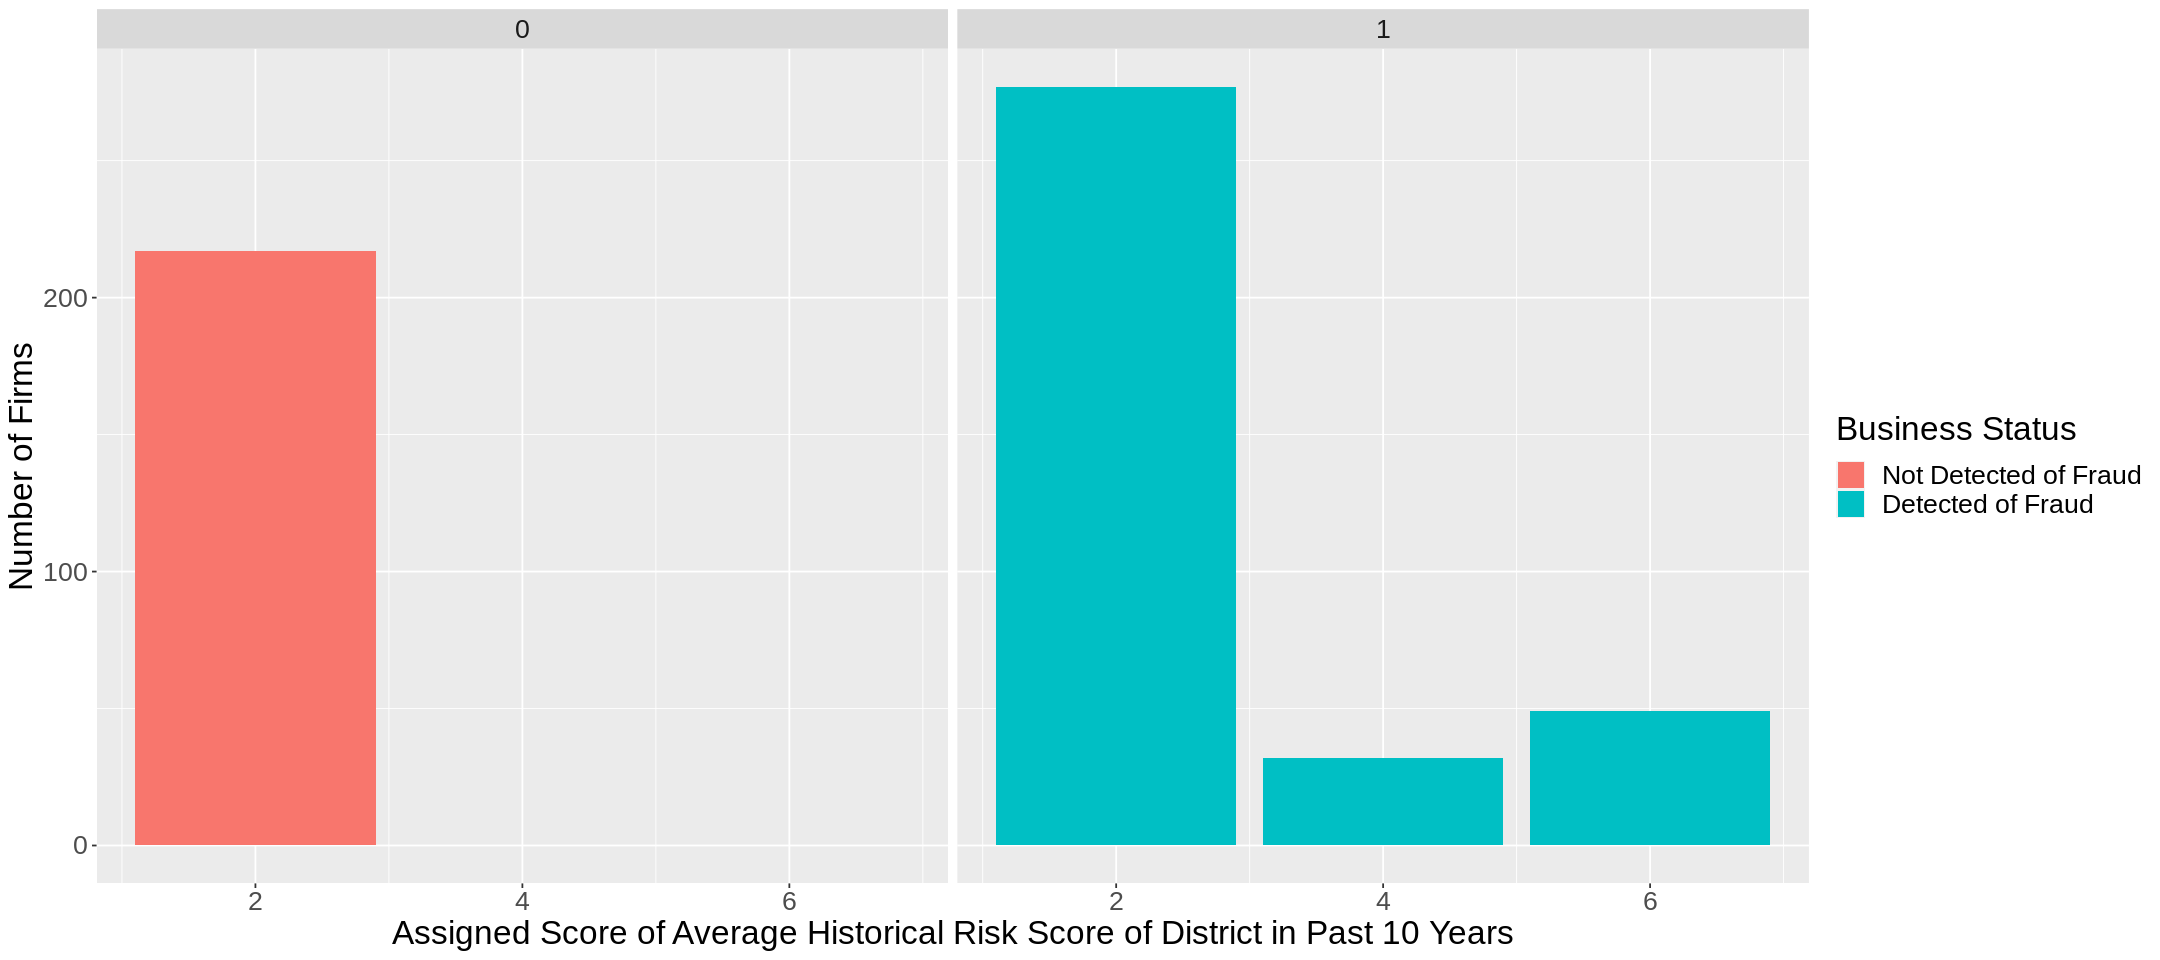

In [9]:
# CONTROL RISK FACTORS
sector
loss
history
district

## Method

In our study, we will use the K-nearest neighbors classification model to best predict whether an Indian business firm is fraudulent based on 3 inherent risk factors and 4 control risk factors. We chose these variables:
- PARA_A and PARA_B: the difference between planned and unplanned expenditures of a company versus the actual expenditures auditors discover, respectively
- Money_Value: Amount of money involved in misstatements in the past audits
- Sector_score”, “Loss_score”, “District”, and “History_score”: the risk score based on a company’s sector, past year financial loss, the administrative district a company is located in, and historic financial loss in the past decade

We choose the 3 inherent risk factors variables because a large gap between a company's reported and actual financial status can indicate that a company is not disclosing practices and the 4 control risk factors indicate that a certain background of a company is associated with higher possibility of committing fraud.

We will conduct a cross-validation on the initial model to find the K that yields the highest accuracy. It will then be fitted to the training data, and we will test the model’s accuracy using the testing data.

Our final visualization will be a bar graph with two bars, each bar representing firms detected/not detected of fraud with a certain portion of them coloured in to indicate the portion of firms with their fraud status correctly predicted by our model. We will also visualize the data in a 2x2 confusion matrix, revealing the accuracy of our model on the test data.

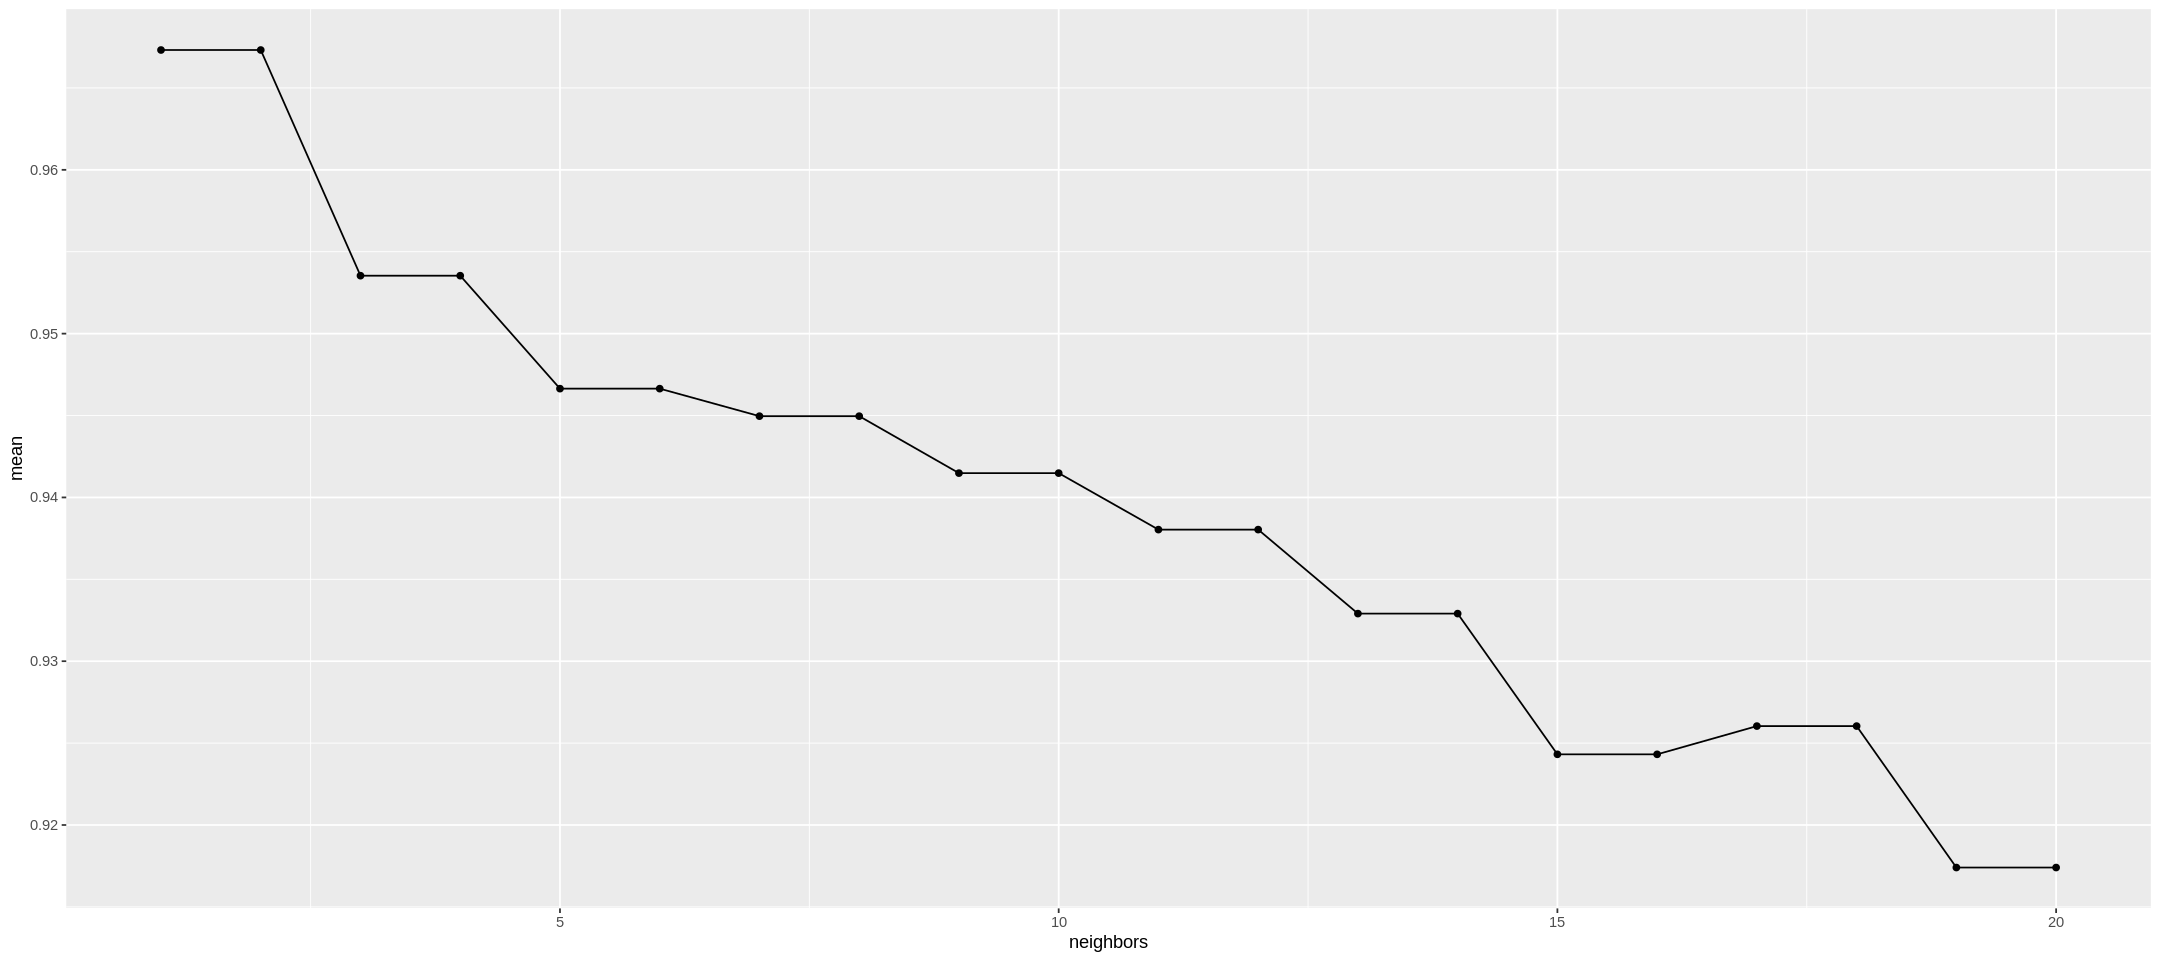

In [10]:
# 1. tune model
# 2. recipe
# 3. make vfold
# 4. collect metrics
# 5. plot k
# 6. choose k
# 7. make new model
# 8. fit training
# 9. predict testing
# 10. metrics & conf mat

knn_recipe <- recipe(Risk ~ PARA_A + PARA_B + Money_Value + Sector_score + LOSS_SCORE + History_score + District, data = audit_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

k_lots <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = audit_vfold, grid = k_lots) |>
    collect_metrics()

cross_val_plot <- knn_results |> filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
        geom_point()+
        geom_line()

cross_val_plot

In [11]:
# ADD WHY WE CHOOSE K = 1, TALK ABOUT WHY K DOESNT LOOK LIKE NORMAL IN DISCUSSION (LIKELY BECAUSE OF AMOUNT OF VARIABLES WE INCLUDED COMPARED TO IN CLASS)

## Expected Outcome and Significance

We expect to create a classifier that can accurately predict whether a firm in India is fraudulent based on the 7 inherent and control risk factors. We hope this model will help Indian auditors find out whether a firm is likely to be fraudulent based on their audit data faster.

Some questions that the results may lead to are: 

- How can this model apply to a larger geographical extent (in addition to India) and more types of companies? 
- How is each variable related to whether or not a firm is fraudulent?
- How would weighting the variables affect the prediction? 

### Citations

https://archive.ics.uci.edu/ml/datasets/Audit+Data

Nishtha Hooda, Seema Bawa & Prashant Singh Rana (2018) Fraudulent Firm
Classification: A Case Study of an External Audit, Applied Artificial Intelligence, 32:1, 48-64, DOI:
10.1080/08839514.2018.1451032
